# Neural Networks - Models

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 08/01/2025   | Martin | Create   | Created notebook for second part of chapter 6. | 
| 14/01/2025   | Martin | Update   | Finished multilayer model and improvements on linear model | 

# Content

* [Multilayer Neural Network](#introduction)
* [Improving the Linear Model](#improving-linear-model)

# Multilayer Neural Network

Create a neural network with 3 hidden layers. Regression model predicting the actual birth weights of babies, but prediction will apply a threshold -> <2,500grams = 0

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
import requests


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

2025-01-14 14:28:42.996371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 14:28:43.006827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736864923.017973    2099 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736864923.021023    2099 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 14:28:43.033950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Get data

# name of data file
birth_weight_file = "birth_weight.csv"

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows([birth_header])
        writer.writerows(birth_data)
        f.close()

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]


# Extract y-target (birth weight)
y_vals = np.array([x[8] for x in birth_data])

# Filter for features of interest
cols_of_interest = ['AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI']
x_vals = np.array([[x[ix] for ix, feature in enumerate(birth_header) if feature in cols_of_interest] for x in birth_data])

In [3]:
x_vals

array([[ 28., 113.,   1., ...,   1.,   0.,   1.],
       [ 29., 130.,   0., ...,   0.,   0.,   1.],
       [ 34., 187.,   1., ...,   0.,   1.,   0.],
       ...,
       [ 19., 120.,   0., ...,   0.,   1.,   0.],
       [ 24., 216.,   0., ...,   0.,   0.,   0.],
       [ 45., 123.,   0., ...,   1.,   0.,   0.]])

In [4]:
# Set the model parameters
BATCH_SIZE = 150

seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)

# Split data into train/ test - 80/20
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [5]:
# Perform data processing
## Scaling dataset by min/max (normalisation) of training set

# Record training column max and min for scaling of non-training data
train_max = np.max(x_vals_train, axis=0)
train_min = np.min(x_vals_train, axis=0)

# Normalize by column (min-max norm to be between 0 and 1)
def normalize_cols(mat, max_vals, min_vals):
  return (mat - min_vals) / (max_vals - min_vals)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train, train_max, train_min))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test, train_max, train_min))

In [6]:
# Define variables, bias and placeholders
# Define Variable Functions (weights and bias)
def init_weight(shape, st_dev):
  weight = tf.Variable(tf.random.normal(shape, stddev=st_dev))
  return(weight)

def init_bias(shape, st_dev):
  bias = tf.Variable(tf.random.normal(shape, stddev=st_dev))
  return(bias)

In [12]:
# Define the model architecture

# Input layer
x_data = tf.keras.Input(dtype=tf.float32, shape=(7,))

# Define a fully connected layer function
def fully_connected(input_layer, weights, biases):
  return tf.keras.layers.Lambda(lambda x: tf.nn.relu(tf.add(tf.matmul(x, weights), biases)))(input_layer)

# First layer
weight_1 = init_weight(shape=[7, 25], st_dev=5.0)
bias_1 = init_bias(shape=[25], st_dev=10.0)
layer_1 = fully_connected(x_data, weight_1, bias_1)

# Second layer
weight_2 = init_weight(shape=[25, 10], st_dev=5.0)
bias_2 = init_bias(shape=[10], st_dev=10.0)
layer_2 = fully_connected(layer_1, weight_2, bias_2)

# Third layer
weight_3 = init_weight(shape=[10, 3], st_dev=5.0)
bias_3 = init_bias(shape=[3], st_dev=10.0)
layer_3 = fully_connected(layer_2, weight_3, bias_3)

# Ouput layer
weight_4 = init_weight(shape=[3, 1], st_dev=5.0)
bias_4 = init_bias(shape=[1], st_dev=10.0)
final_output = fully_connected(layer_3, weight_4, bias_4)

# Build model
model = tf.keras.Model(inputs=x_data, outputs=final_output, name='multiple _layers_neural_network')
model.summary()

Model: "multiple _layers_neural_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model here has 522 variables.

Between input and first layer: $$7 * 25 + 25 = 200$$ (num features * num nodes + num bias)

Performing the same calucation across the entire model, total number of variables: $$200 + 260 + 33 + 4 = 497$$

In [8]:
# Optimiser
optmiser = tf.keras.optimizers.Adam(0.025)

# Training loop
loss_vec = []
test_loss = []

for i in range(200):
  rand_index = np.random.choice(len(x_vals_train), size=BATCH_SIZE)
  rand_x = x_vals_train[rand_index]
  rand_y = np.transpose([y_vals_train[rand_index]])

  # Open gradientTape
  with tf.GradientTape(persistent=True) as tape:
    #  Prediction
    preds = model(rand_x)

    # Get loss
    loss = tf.reduce_mean(tf.abs(rand_y - preds))
    loss_vec.append(loss)

  # Get individual gradients
  gradients_w1 = tape.gradient(loss, weight_1)
  gradients_b1 = tape.gradient(loss, bias_1)
  gradients_w2 = tape.gradient(loss, weight_2)
  gradients_b2 = tape.gradient(loss, bias_2)
  gradients_w3 = tape.gradient(loss, weight_3)
  gradients_b3 = tape.gradient(loss, bias_3)
  gradients_w4 = tape.gradient(loss, weight_4)
  gradients_b4 = tape.gradient(loss, bias_4)

  # Update the weights values
  optmiser.apply_gradients(zip(
    [
      gradients_w1,
      gradients_b1,
      gradients_w2,
      gradients_b2,
      gradients_w3,
      gradients_b3,
      gradients_w4,
      gradients_b4,
    ],
    [
      weight_1,
      bias_1,
      weight_2,
      bias_2,
      weight_3,
      bias_3,
      weight_4,
      bias_4,
    ]
  ))

  test_output = model(x_vals_test)
  temp_loss = tf.reduce_mean(np.abs(np.transpose([y_vals_test]) - test_output))
  test_loss.append(temp_loss)

  if (i+1) % 25 == 0:
    print('Generation: ' + str(i+1) + '. Loss = ' + str(loss.numpy()))

Generation: 25. Loss = 1921.8654
Generation: 50. Loss = 1452.7343
Generation: 75. Loss = 987.5854
Generation: 100. Loss = 709.25836
Generation: 125. Loss = 509.86124
Generation: 150. Loss = 540.57904
Generation: 175. Loss = 535.9691
Generation: 200. Loss = 439.15448


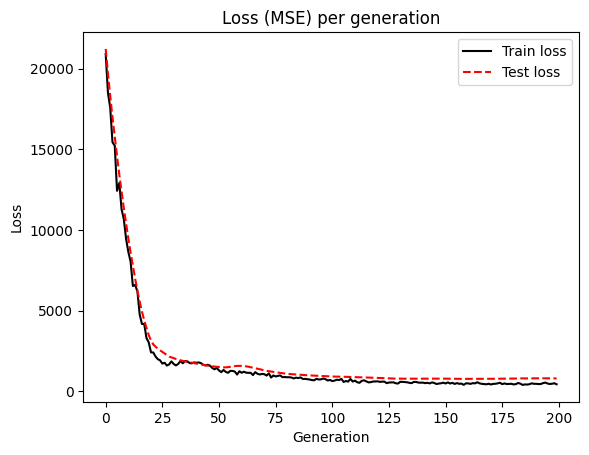

In [9]:
%matplotlib inline

plt.plot(loss_vec, 'k', label='Train loss')
plt.plot(test_loss, 'r--', label='Test loss')
plt.title('Loss (MSE) per generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [10]:
# Performance
actuals = np.array([x[0] for x in birth_data])
test_actuals = actuals[test_indices]
train_actuals = actuals[train_indices]
test_preds = model(x_vals_test)
train_preds = model(x_vals_train)
test_preds = np.array([1.0 if x < 2500.0 else 0.0 for x in test_preds])
train_preds = np.array([1.0 if x < 2500.0 else 0.0 for x in train_preds])

# Print accuracy
test_acc = np.mean([x == y for x, y in zip(test_preds, test_actuals)])
train_acc = np.mean([x == y for x, y in zip(train_preds, train_actuals)])
print('On predicting the category of low birthweight from regression output (<2500g):')
print(f"Test Accuracy: {test_acc}")
print(f"Train Accuracy: {train_acc}")

On predicting the category of low birthweight from regression output (<2500g):
Test Accuracy: 0.7631578947368421
Train Accuracy: 0.7748344370860927


In [11]:
# Evaluating new points on the model
# Need new vectors of 'AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI'
new_data = np.array([[35, 185, 1., 0., 0., 0., 1.],
                     [18, 160, 0., 1., 0., 0., 1.]])
new_data_scaled = np.nan_to_num(normalize_cols(new_data, train_max, train_min))
new_logits = model(new_data_scaled)
new_preds = np.array([1.0 if x < 2500.0 else 0.0 for x in new_logits])

print(f"New data predictions: {new_preds}")

New data predictions: [1. 0.]


## Interpreting results

* Decent performance for train and test accuracy at ~70+% each
* With the limited amount of data (151 data points) performance is quite decent, usually NN require more data to better pick up on relationships and signals

---

# Improving Linear Model

Instead of using a regression model with linear methods, apply the sigmoid function in the middle layers to help the model learn faster.

In [2]:
# Get data

# name of data file
birth_weight_file = "birth_weight.csv"

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows([birth_header])
        writer.writerows(birth_data)
        f.close()

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]

# Extract out variables
## Target variables
y_vals = np.array([x[0] for x in birth_data])
## Features
x_vals = np.array([x[1:8] for x in birth_data])

In [3]:
# Set the seed 
seed = 98
np.random.seed(seed)
tf.random.set_seed(seed)

# Declare Hyperparameters
BATCH_SIZE = 90

# Split into training/ testing set
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
y_vals_train = y_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_test = y_vals[test_indices]

In [4]:
# Data Processing

## Normalise each of the columns
def normalize_cols(m):
  col_max = m.max(axis=0)
  col_min = m.min(axis=0)
  return (m - col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [5]:
# Set the seed 
seed = 98
np.random.seed(seed)
tf.random.set_seed(seed)

# Define the model
tf.keras.backend.set_floatx("float64")

# Input layer
x_data = tf.keras.Input(dtype=tf.float64, shape=(7,))

# Variable definintion
def init_variable(shape):
  return (tf.Variable(tf.random.normal(shape=shape, dtype='float64', seed=seed)))

def logistic(input_layer, multiplication_weight, bias_weight, activation=True):
  # Separate the activation at the end becuase the loss function will implement the last sigmoid necessary
  if activation:
    return tf.keras.layers.Lambda(
      lambda x: tf.nn.sigmoid(tf.add(tf.matmul(x, multiplication_weight), bias_weight))
    )(input_layer)
  else:
    return tf.keras.layers.Lambda(
      lambda x: tf.add(tf.matmul(x, multiplication_weight), bias_weight)
    )(input_layer)

# First layer
A1 = init_variable(shape=[7, 14])
b1 = init_variable(shape=[14])
first_logistic = logistic(x_data, A1, b1)

# Second layer
A2 = init_variable(shape=[14, 5])
b2 = init_variable(shape=[5])
second_logistic = logistic(first_logistic, A2, b2)

# Final layer
A3 = init_variable(shape=[5, 1])
b3 = init_variable(shape=[1])
final_layer = logistic(second_logistic, A3, b3, activation=False)

# Define the model
model = tf.keras.Model(inputs=x_data, outputs=final_layer, name="improved_lin_reg_nn")

model.summary()

W0000 00:00:1736864947.723590    2099 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "improved_lin_reg_nn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Set the seed 
seed = 98
np.random.seed(seed)
tf.random.set_seed(seed)

optimiser = tf.keras.optimizers.Adam(0.002)

# Accuracy
def compute_accuracy(final_output, y_target):
  prediction = tf.round(tf.nn.sigmoid(final_output))
  predictions_correct = tf.cast(tf.equal(prediction, y_target), dtype=tf.float64)
  return tf.reduce_mean(predictions_correct)

# Loss function (cross entropy loss)
def cross_entropy(final_output, y_target):
  return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_output, labels=y_target))

loss_vec = []
train_acc = []
test_acc = []

for i in range(1500): # more training loops compared to previous example
  rand_index = np.random.choice(len(x_vals_train), size=BATCH_SIZE)
  rand_x = tf.cast(x_vals_train[rand_index], dtype=tf.float64)
  rand_y = np.transpose(tf.cast([y_vals_train[rand_index]], dtype=tf.float64))

  with tf.GradientTape(persistent=True) as tape:
    # Get predictions
    preds = model(rand_x)

    # Get loss
    loss = cross_entropy(preds, rand_y)
    loss_vec.append(loss)
  
  # Get gradients for all variables
  gradients_A1 = tape.gradient(loss, A1)
  gradients_b1 = tape.gradient(loss, b1)
  gradients_A2 = tape.gradient(loss, A2)
  gradients_b2 = tape.gradient(loss, b2)
  gradients_A3 = tape.gradient(loss, A3)
  gradients_b3 = tape.gradient(loss, b3)

  # Update current set of weights
  optimiser.apply_gradients(zip(
    [
      gradients_A1,
      gradients_b1,
      gradients_A2,
      gradients_b2,
      gradients_A3,
      gradients_b3
    ],
    [
      A1,
      b1,
      A2,
      b2,
      A3,
      b3
    ]
  ))

  temp_acc_train = compute_accuracy(model(x_vals_train), np.transpose([y_vals_train]))
  train_acc.append(temp_acc_train)

  temp_acc_test = compute_accuracy(model(x_vals_test), np.transpose([y_vals_test]))
  test_acc.append(temp_acc_test)

  if (i+1) % 150 == 0:
    print(f"Loss: {loss.numpy()}")

Loss: 0.6213783638001852
Loss: 0.5917431416200124
Loss: 0.6352656465817249
Loss: 0.5757782438119211
Loss: 0.5242739983274022
Loss: 0.5060574177311837
Loss: 0.5679448723329099
Loss: 0.49322154944475544
Loss: 0.5643466583091536
Loss: 0.5065505966510369


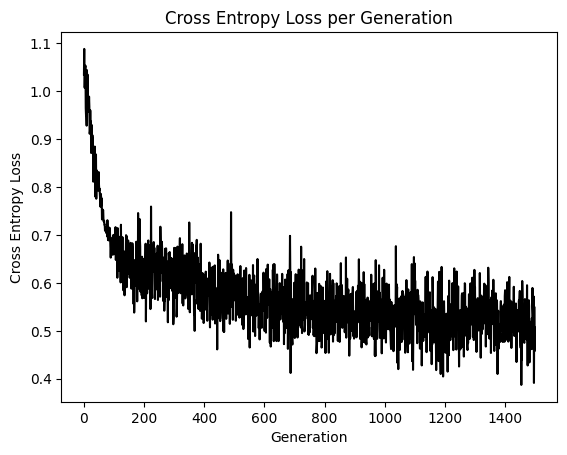

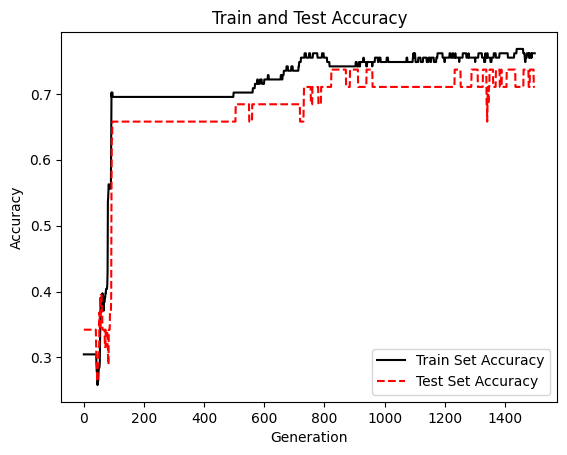

In [7]:
%matplotlib inline
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Interpreting Results

* Overall model accuracy seems to remain about the same
* Convergence is much faster compared to purely linear model
* Consider the tradeoff - converges faster, but more variables means more chances to overfit

## Additional Tips
* To combat underfitting, increase the model depth or increase the number of iterations
* To combat overfitting, include regularisation

---

# Learning to play Tic-Tac-Toe

pg 275